## Healthcare SalesWizard Lead Scoring and Prioritization

The purpose of this notebook is to build machine learning models to help company leadership make better sales decisions in the context of lead prioritization.  The two models that will be created are multi-variate logistic regression and random forest.

### Load and Preprocess Dataset

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install brokenaxes

In [143]:
df = pd.read_csv("leadscore_dataset.csv")

In [144]:
df.head()

,business_unit,lead_contact,title,job_level,industry,team,channel,lead_product,sales_qualified
0,business_unit_1,Contact,Billing Coordinator,Staff-Level,Assisted Living Facility,team_1,Webinar,product_7,0
1,business_unit_1,Contact,Billing Specialist,Staff-Level,Home Health,team_1,Webinar,product_27,0
2,business_unit_1,Lead,Executive Director,NaN,Assisted Living Facility,team_1,MDR Meeting,product_40,0
3,business_unit_1,Contact,Billing,NaN,Ambulatory Health Care Facilities,team_2,Inbound Call,product_1,0
4,business_unit_1,Lead,Billing Director,Director-Level,Physician,team_3,Webinar,product_27,0


#### Understanding the Variables
* business_unit: Often, organizations will split product offerings into "Business Units". Business Units are supported by different Sales Teams.*ead_contact: Indicates whether the person is known to the database (Contact) or is net new (Lead).
* title: Job title of the lead.
* job_level: Job level of the lead.
* industry: Industry of the person identified as a lead.
* team: Sales team which will be working with the lead (Often determined by industry and product combinations).
* channel: Activity channel the person took to become a lead.
* lead_product: Product of interest of the lead.
* sales_qualified: Target variable. This is the metric used to determine a success (1) or a failure (0).

In [145]:
# Number of rows and columns
df.shape

(10000, 9)

In [146]:
# Check for missing values
df.isnull().sum()

business_unit         0
lead_contact          0
title               957
job_level          4967
industry             58
team                  0
channel               0
lead_product          3
sales_qualified       0
dtype: int64

In [147]:
# Impute 'Unknown' for missing values
df.fillna('Unknown', inplace=True)

In [148]:
# Check data types
df.dtypes

business_unit      object
lead_contact       object
title              object
job_level          object
industry           object
team               object
channel            object
lead_product       object
sales_qualified     int64
dtype: object

### Exploratory Data Analysis

#### Univariate Analysis

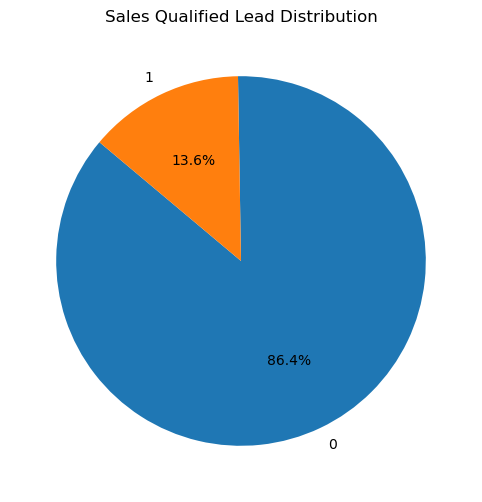

In [149]:
# Pie Chart of Unqualified versus Qualified leads
sales_qualified_counts = df['sales_qualified'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(sales_qualified_counts, labels=sales_qualified_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Qualified Lead Distribution')
plt.show()

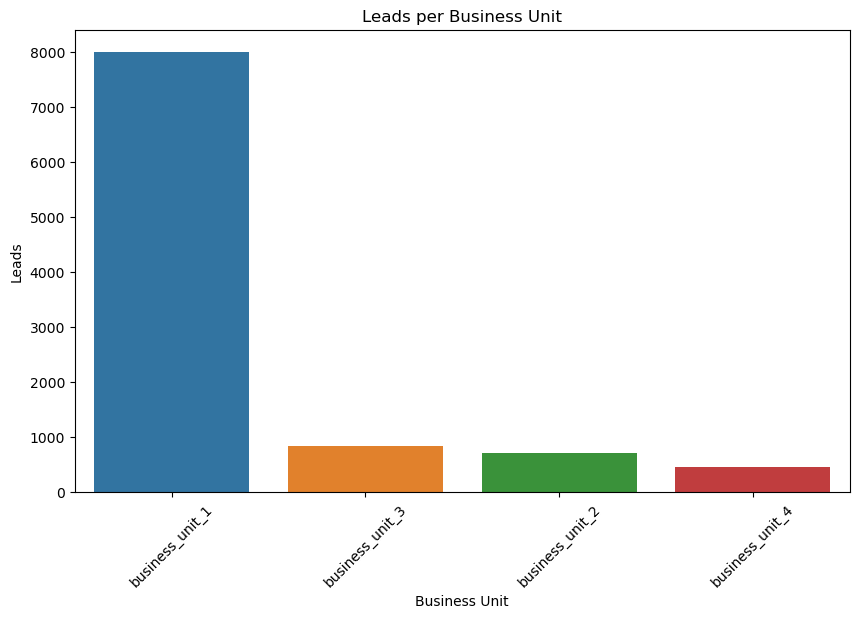

In [150]:
# Create a bar chart
business_unit_counts = df['business_unit'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=business_unit_counts.index, y=business_unit_counts.values)
plt.title('Leads per Business Unit')
plt.xlabel('Business Unit')
plt.ylabel('Leads')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

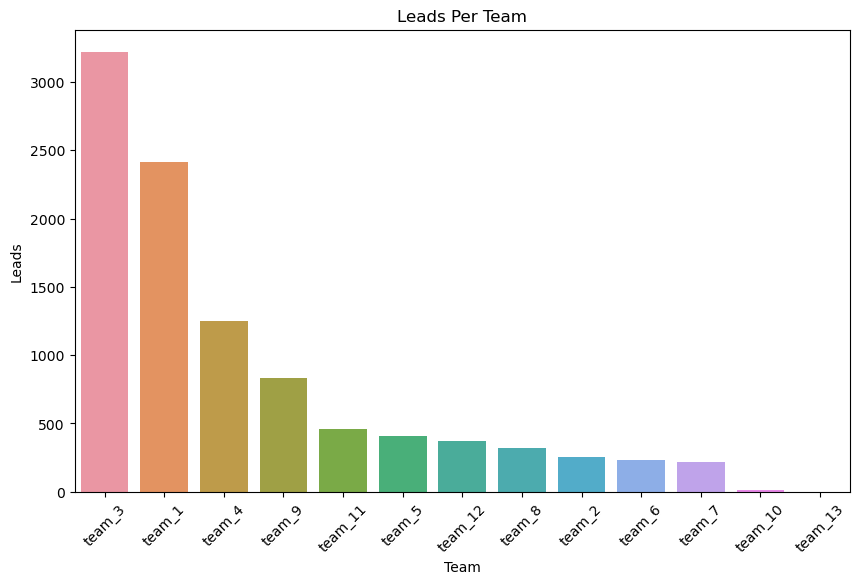

In [151]:
# Bar Chart for Leads per Team
team_counts = df['team'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=team_counts.index, y=team_counts.values)
plt.title('Leads Per Team')
plt.xlabel('Team')
plt.ylabel('Leads')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

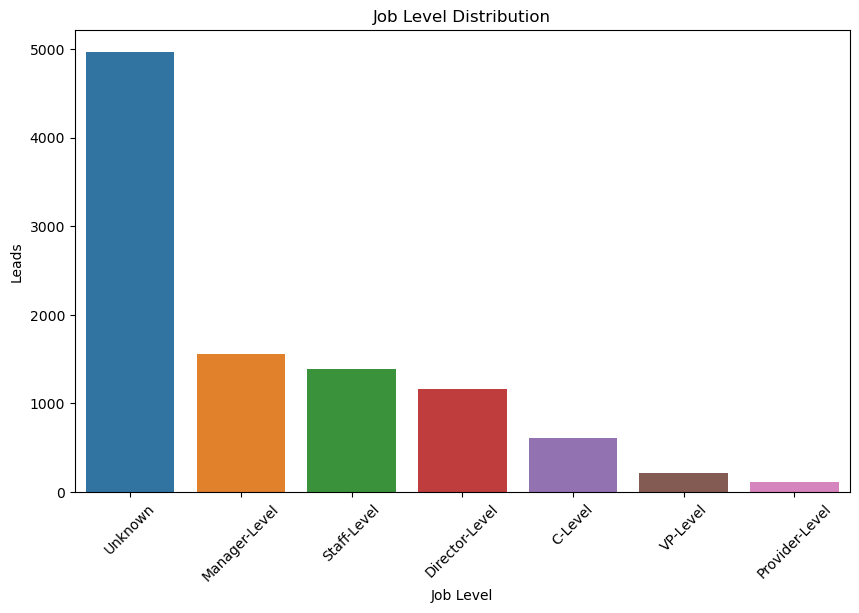

In [152]:
# Bar chart for Job Level Distribution
job_level_counts = df['job_level'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=job_level_counts.index, y=job_level_counts.values)
plt.title('Job Level Distribution')
plt.xlabel('Job Level')
plt.ylabel('Leads')
plt.xticks(rotation=45) 
plt.show()

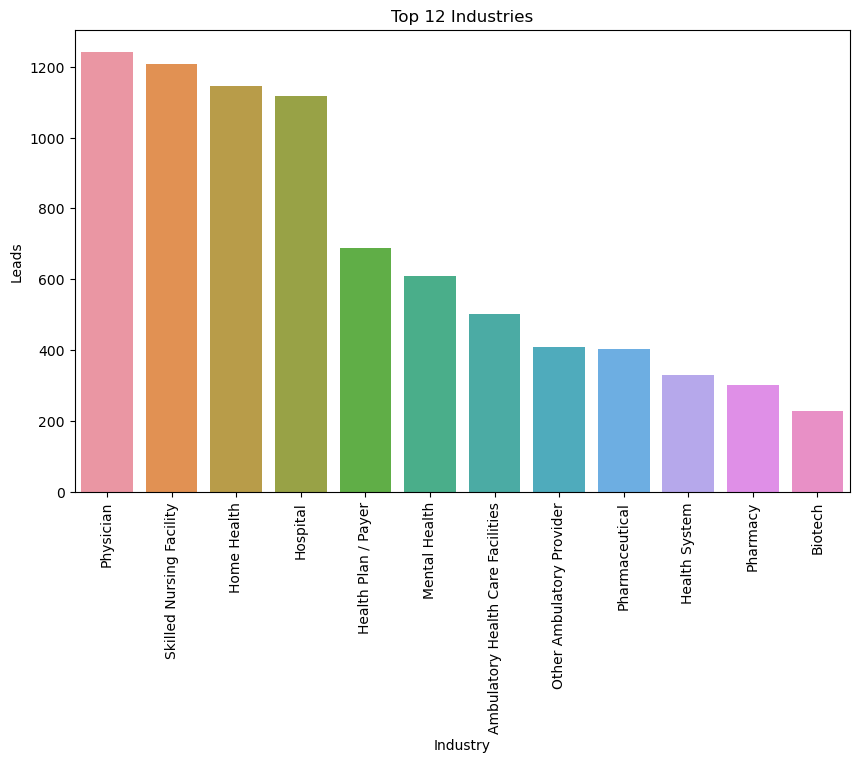

In [153]:
# Bar chart for top lead industries
top_12_industries = df.industry.value_counts().head(12)
plt.figure(figsize=(10,6))
sns.barplot(x=top_12_industries.index, y=top_12_industries.values)
plt.title('Top 12 Industries')
plt.xlabel('Industry')
plt.ylabel('Leads')
plt.xticks(rotation=90)
plt.show()

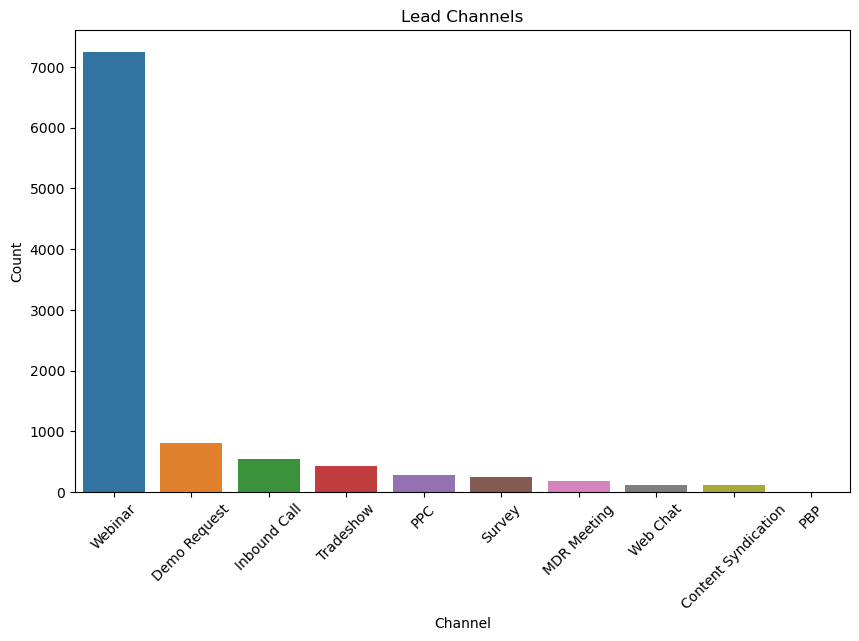

In [154]:
# Bar chart for channels of the leads
channel_counts = df['channel'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=channel_counts.index, y=channel_counts.values)
plt.title('Lead Channels')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#### Bivariate Analysis
As the focus of this analysis and ML building is geared toward where to prioritize resources for winning leads, bivariate analyses will focus on the target variable.  Categorical variables will be encoded accordingly for proper analysis.

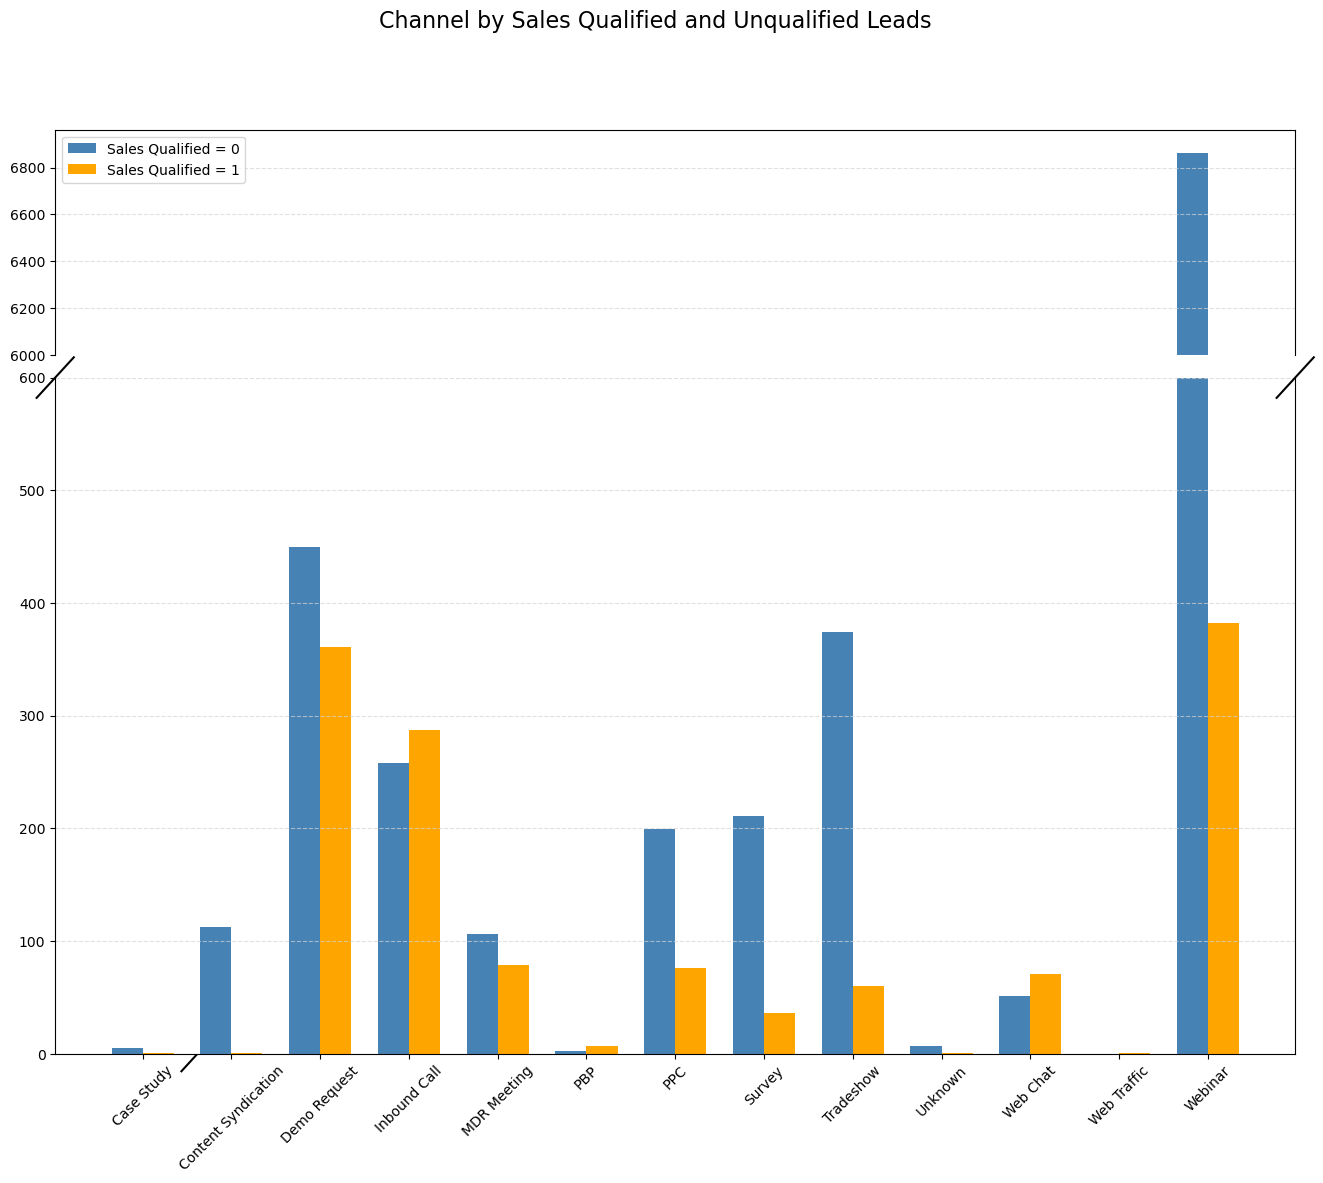

In [178]:
# Example aggregated data for plotting; replace with your DataFrame aggregation
channel_counts = df.groupby(['channel', 'sales_qualified'], observed=False).size().unstack(fill_value=0)

# Plot parameters
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 12), gridspec_kw={'height_ratios': [1, 3]})
width = 0.35  # Width of the bars
x = np.arange(len(channel_counts))  # The label locations

# Top plot (ax1) with y-axis break
ax1.bar(x - width/2, channel_counts[0], width, label='Sales Qualified = 0', color='steelblue')
ax1.bar(x + width/2, channel_counts[1], width, label='Sales Qualified = 1', color='orange')
ax1.set_ylim(6000, channel_counts.max().max() + 100)  # Adjust upper limit as needed

# Bottom plot (ax2) with y-axis break
ax2.bar(x - width/2, channel_counts[0], width, label='Sales Qualified = 0', color='steelblue')
ax2.bar(x + width/2, channel_counts[1], width, label='Sales Qualified = 1', color='orange')
ax2.set_ylim(0, 600)  # Lower limit of the second subplot

ax1.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7, zorder=0)
ax2.grid(axis='y', linestyle='--', color='lightgray', alpha=0.7, zorder=0) 

# Hide the spines between ax1 and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False, top=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Modify the x and y values to change the angle of the break lines
# Adjusted angles for top-left and top-right break markers
ax1.plot((-d, +d), (-d * 2, +d * 2), **kwargs)        # Top-left diagonal, steeper angle
ax1.plot((1 - d, 1 + d), (-d * 2, +d * 2), **kwargs)  # Top-right diagonal, steeper angle

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes

# Adjusted angles for bottom-left and bottom-right break markers
ax2.plot((-d, +d), (1 - d * 2, 1 + d * 2), **kwargs)  # Bottom-left diagonal, steeper angle
ax2.plot((1 - d, 1 + d), (1 - d * 2, 1 + d * 2), **kwargs) 

# Customization
ax2.set_xticks(x)
ax2.set_xticklabels(channel_counts.index, rotation=45)  # Rotate x-axis labels by 45 degrees
ax1.legend()

# Add title
plt.suptitle('Channel by Sales Qualified and Unqualified Leads', fontsize=16)

# Align y-axis scales visually for continuity
plt.subplots_adjust(hspace=0.05)  # Reduce space between plots for visual continuity
plt.show()

The most qualified leads come from Webinars and Demo Requests and Inbound calls.  The only channels with more qualified leads than unqualified leads are inbound calls, PBP and web chats.

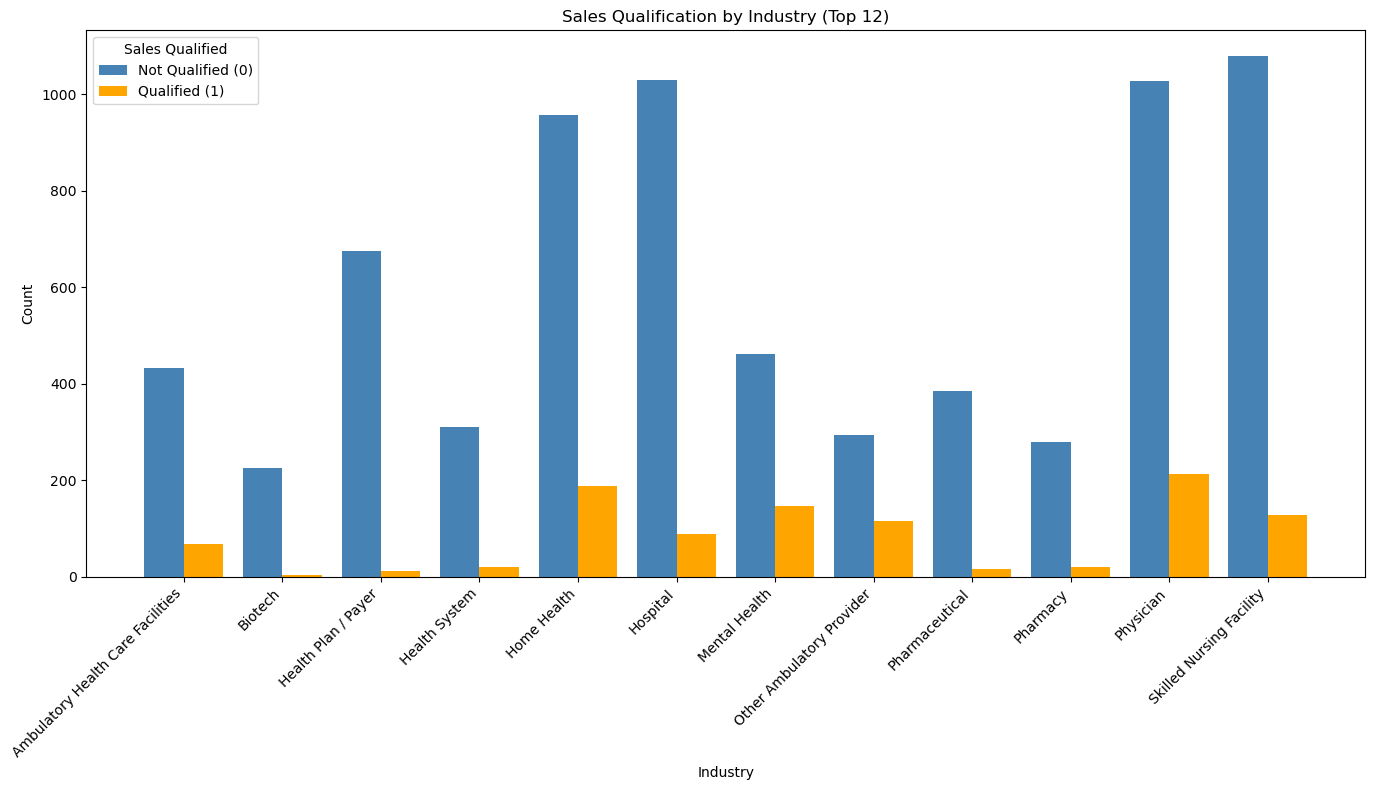

In [183]:
# Get the top 12 industries by count
top_industries = df['industry'].value_counts().nlargest(12).index
filtered_df = df[df['industry'].isin(top_industries)]

# Group by industry and sales_qualified to get the counts
industry_qualified_counts = filtered_df.groupby(['industry', 'sales_qualified'], observed=False).size().unstack(fill_value=0)

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Set the bar width
bar_width = 0.4
indices = range(len(industry_qualified_counts))

# Plot each sales qualification (0 and 1)
ax.bar([i - bar_width / 2 for i in indices], industry_qualified_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar([i + bar_width / 2 for i in indices], industry_qualified_counts[1], width=bar_width, label='Qualified (1)', color='orange')

# Set labels and title
ax.set_xlabel('Industry')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Industry (Top 12)')
ax.set_xticks(indices)
ax.set_xticklabels(industry_qualified_counts.index, rotation=45, ha='right')

# Add a legend
ax.legend(title='Sales Qualified')

# Show the plot
plt.tight_layout()
plt.show()

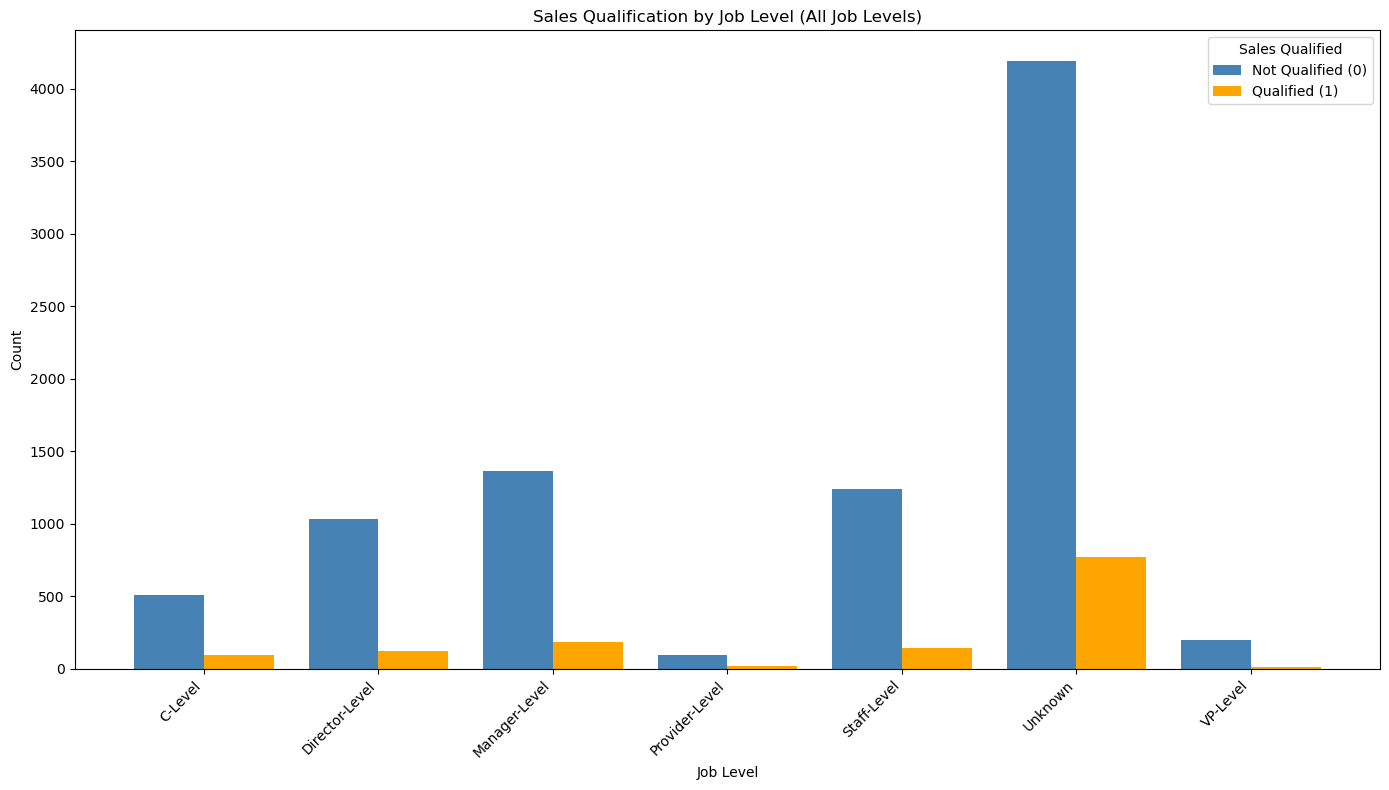

In [187]:
# Group by job_level and sales_qualified to get the counts
job_level_qualified_counts = df.groupby(['job_level', 'sales_qualified'], observed=False).size().unstack(fill_value=0)

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Set the bar width
bar_width = 0.4
indices = range(len(job_level_qualified_counts))

# Plot each sales qualification (0 and 1)
ax.bar([i - bar_width / 2 for i in indices], job_level_qualified_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar([i + bar_width / 2 for i in indices], job_level_qualified_counts[1], width=bar_width, label='Qualified (1)', color='orange')

# Set labels and title
ax.set_xlabel('Job Level')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Job Level (All Job Levels)')
ax.set_xticks(indices)
ax.set_xticklabels(job_level_qualified_counts.index, rotation=45, ha='right')

# Add a legend
ax.legend(title='Sales Qualified')

# Show the plot
plt.tight_layout()
plt.show()

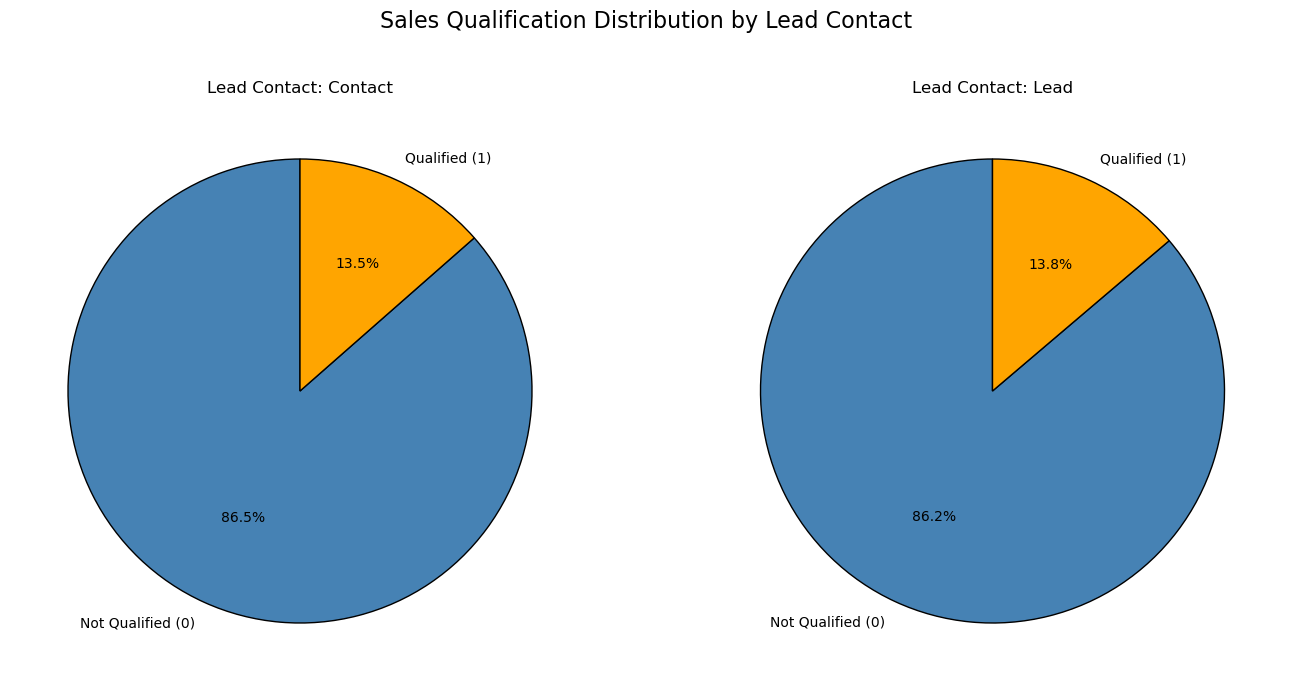

lead_contact
Contact    5922
Lead       4078
Name: count, dtype: int64


In [191]:
# Get unique lead_contact values
lead_contact_types = df['lead_contact'].unique()

# Set up the plot with two pie charts
fig, axes = plt.subplots(1, len(lead_contact_types), figsize=(14, 7))

# Iterate through each lead_contact type to create a pie chart
for i, contact_type in enumerate(lead_contact_types):
    # Filter data for the current lead_contact type
    filtered_data = df[df['lead_contact'] == contact_type]
    
    # Count the values of sales_qualified (0 and 1)
    sales_counts = filtered_data['sales_qualified'].value_counts().reindex([0, 1], fill_value=0)

    # Plot pie chart for each lead_contact
    axes[i].pie(
        sales_counts,
        labels=['Not Qualified (0)', 'Qualified (1)'],
        autopct='%1.1f%%',
        colors=['steelblue', 'orange'],
        startangle=90,
        wedgeprops={'edgecolor': 'black'}
    )
    axes[i].set_title(f'Lead Contact: {contact_type}')

# Set a super title for the figure
fig.suptitle('Sales Qualification Distribution by Lead Contact', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Add some space for the suptitle

# Show the plot
plt.show()
lead_contact_counts = df['lead_contact'].value_counts()

# Print the counts
print(lead_contact_counts)

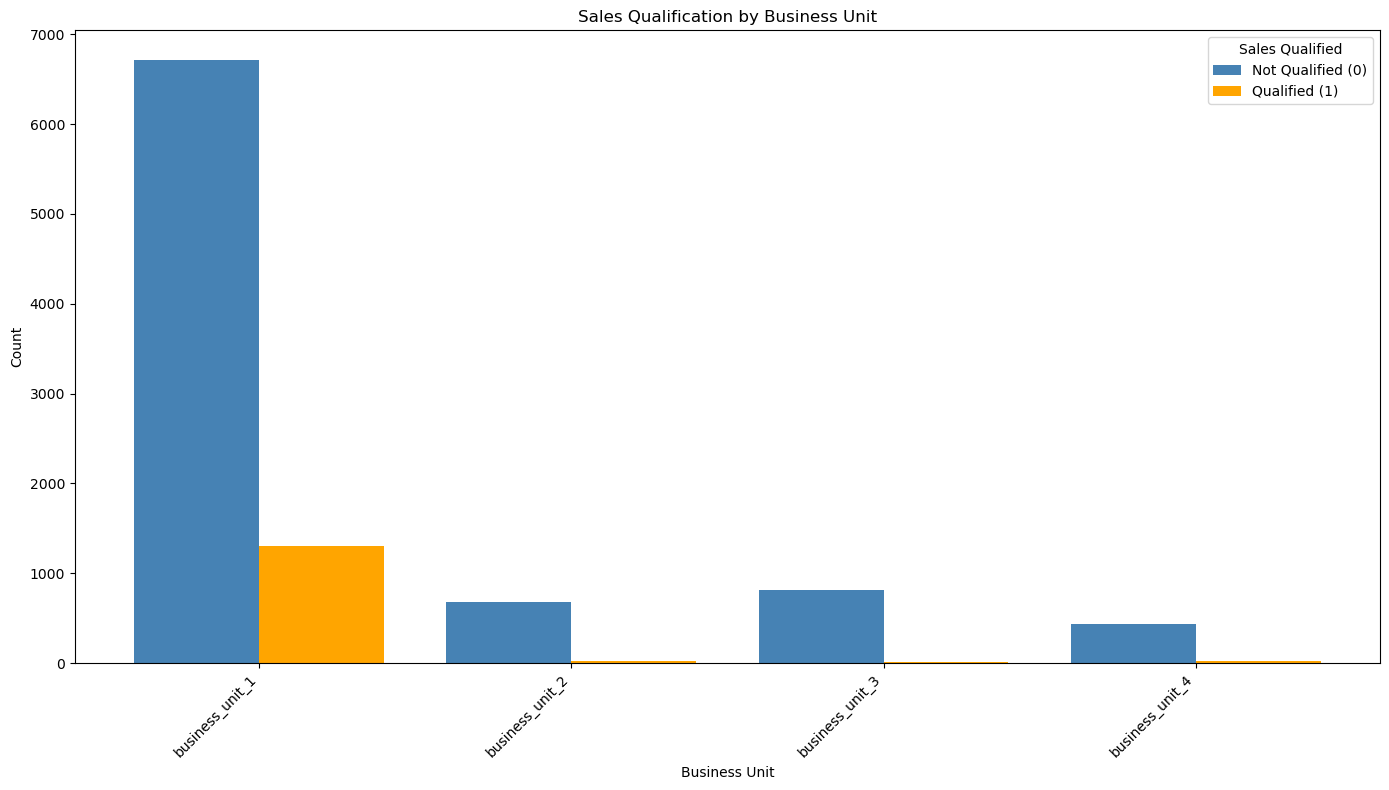

In [194]:
# Group by business_unit and sales_qualified to get the counts
business_unit_qualified_counts = df.groupby(['business_unit', 'sales_qualified'],observed=False).size().unstack(fill_value=0)

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Set the bar width
bar_width = 0.4
indices = range(len(business_unit_qualified_counts))

# Plot each sales qualification (0 and 1)
ax.bar([i - bar_width / 2 for i in indices], business_unit_qualified_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar([i + bar_width / 2 for i in indices], business_unit_qualified_counts[1], width=bar_width, label='Qualified (1)', color='orange')

# Set labels and title
ax.set_xlabel('Business Unit')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Business Unit')
ax.set_xticks(indices)
ax.set_xticklabels(business_unit_qualified_counts.index, rotation=45, ha='right')

# Add a legend
ax.legend(title='Sales Qualified')

# Show the plot
plt.tight_layout()
plt.show()

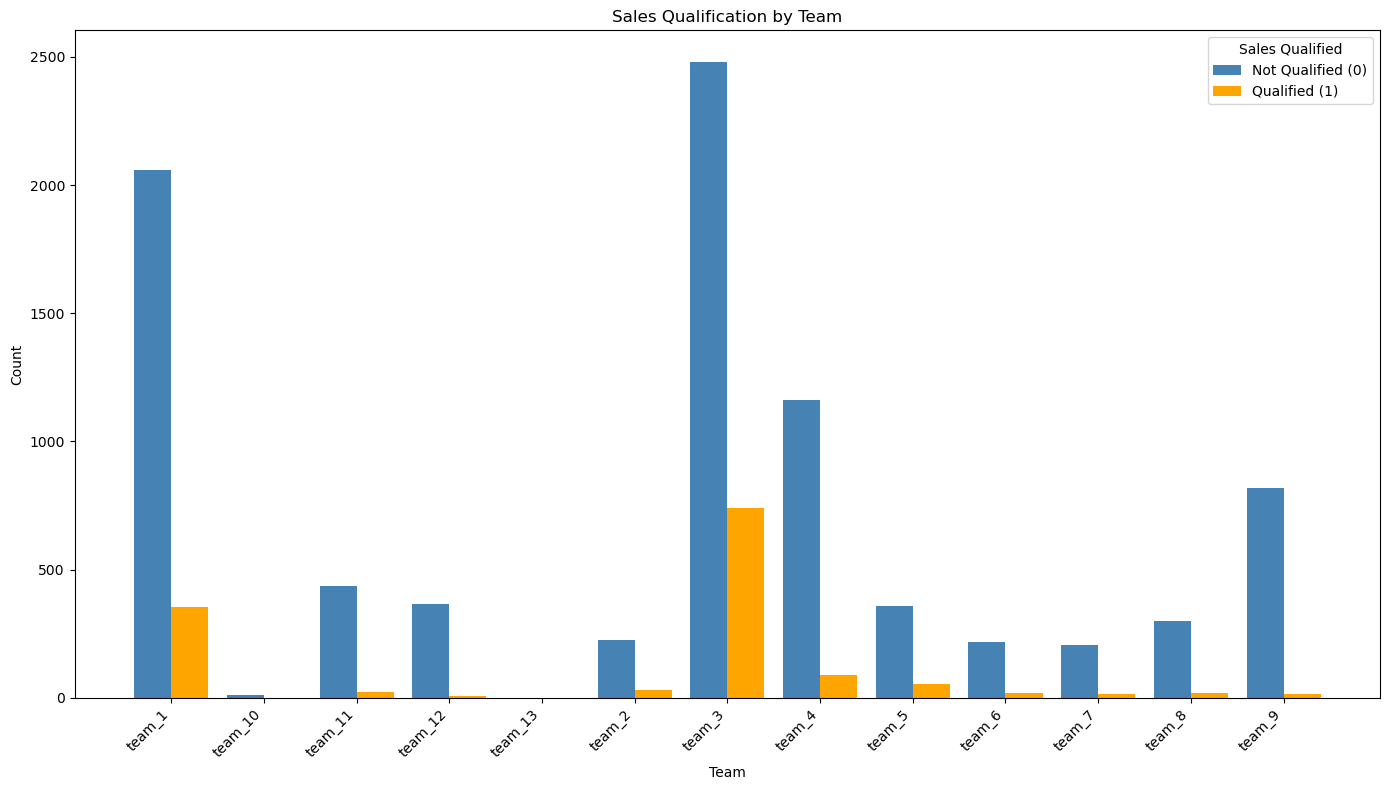

In [197]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Group by team and sales_qualified to get the counts
team_qualified_counts = df.groupby(['team', 'sales_qualified'],observed=False).size().unstack(fill_value=0)

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Set the bar width
bar_width = 0.4
indices = range(len(team_qualified_counts))

# Plot each sales qualification (0 and 1)
ax.bar([i - bar_width / 2 for i in indices], team_qualified_counts[0], width=bar_width, label='Not Qualified (0)', color='steelblue')
ax.bar([i + bar_width / 2 for i in indices], team_qualified_counts[1], width=bar_width, label='Qualified (1)', color='orange')

# Set labels and title
ax.set_xlabel('Team')
ax.set_ylabel('Count')
ax.set_title('Sales Qualification by Team')
ax.set_xticks(indices)
ax.set_xticklabels(team_qualified_counts.index, rotation=45, ha='right')

# Add a legend
ax.legend(title='Sales Qualified')

# Show the plot
plt.tight_layout()
plt.show()


#### Multivariate Analyses
